In [1]:
# See how much memory is used by OS initially.
# Then substract this value from later mem used, to obtain mem used by scripts.
import psutil
GB_UNIT = 1000*1024**2
MB_UNIT = GB_UNIT/1e3
OS_MEM = psutil.virtual_memory().used
print(OS_MEM/GB_UNIT)


from shared.preface import *
import shared.functions as fct


# Initialize parameters and files.
PRE = PRE(
    sim='L012N376', 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=20, thetas=20, vels=200,
    pre_CPUs=8, sim_CPUs=8, mem_lim_GB=12
)


TEMP_DIR = f'X_tests'

Testing = False
if Testing:
    mass_gauge = 12.3
    mass_range = 0.3
    size = 1
else:
    mass_gauge = 12.0
    mass_range = 0.6
    size = 3

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, TEMP_DIR
)
halo_batch_IDs = np.load(f'{TEMP_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{TEMP_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

3.0464609375
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 20, THETAs=20, Vs=200
Total neutrinos: 80000
# Simulation parameters:
Simulation box: L012N376
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 8/8
DM limit for cells: 1000
# File management:
Box files directory: 
 /home/fabian/ownCloud/snellius/L012N376/DMONLY/SigmaConstant00
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/L012N376/DMONLY/SigmaConstant00
**********************************************************
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[195.00028262  11.89848321  13.2646342 ]
 [171.6865726   11.73258648   5.56997953]
 [139.87064301  11.46555721   7.37974116]]
***********************************


In [2]:
# =============================================== #
# Run precalculations for selected halo in batch. #
# =============================================== #

halo_j = 2
halo_ID = halo_batch_IDs[halo_j]

halo_rvir = halo_batch_params[halo_j, 0]
halo_Mvir = halo_batch_params[halo_j, 1]
halo_cNFW = halo_batch_params[halo_j, 2]

# Generate progenitor index array for current halo.
splits = re.split('/', SIM_TYPE)
MTname = f'{PRE.SIM}_{splits[0]}_{splits[1]}'
proj_IDs = fct.read_MergerTree(PRE.OUT_DIR, MTname, halo_ID)


j = 0
snap = PRE.NUMS_SNAPS[::-1][0]
proj_ID = proj_IDs[0]

proj_ID = int(proj_ID)

# Output halo progress.
print(f'halo {halo_j+1}/{halo_num} ; snapshot {snap}')

# --------------------------- #
# Read and load DM positions. #
# --------------------------- #

IDname = f'origID{halo_ID}_snap_{snap}'
fct.read_DM_halo_index(
    snap, proj_ID, IDname, PRE.SIM_DIR, TEMP_DIR
)
DM_raw = np.load(f'{TEMP_DIR}/DM_pos_{IDname}.npy')
DM_particles = len(DM_raw)


# ---------------------- #
# Cell division process. #
# ---------------------- #

# Initialize grid.
snap_GRID_L = (int(np.abs(DM_raw).max()) + 1)*kpc
raw_grid = fct.grid_3D(snap_GRID_L, snap_GRID_L)
init_grid = np.expand_dims(raw_grid, axis=1)

# Prepare arrays for cell division.
DM_raw *= kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_grid), axis=0)
del DM_raw

# Cell division.
cell_division_count = fct.cell_division(
    init_grid, DM_pos_for_cell_division, snap_GRID_L, PRE.DM_LIM, None, TEMP_DIR, IDname
)
del DM_pos_for_cell_division

halo 3/3 ; snapshot 0036


In [3]:
'''
# =============================================== #
# Run precalculations for selected halo in batch. #
# =============================================== #

halo_j = 2
halo_ID = halo_batch_IDs[halo_j]

halo_rvir = halo_batch_params[halo_j, 0]
halo_Mvir = halo_batch_params[halo_j, 1]
halo_cNFW = halo_batch_params[halo_j, 2]

# Generate progenitor index array for current halo.
splits = re.split('/', SIM_TYPE)
MTname = f'{PRE.SIM}_{splits[0]}_{splits[1]}'
proj_IDs = fct.read_MergerTree(PRE.OUT_DIR, MTname, halo_ID)

# Create empty arrays to save specifics of each loop.
save_DM_com = []

j = 0
snap = PRE.NUMS_SNAPS[::-1][0]
proj_ID = proj_IDs[0]

proj_ID = int(proj_ID)

# Output halo progress.
print(f'halo {halo_j+1}/{halo_num} ; snapshot {snap}')


# --------------------------- #
# Read and load DM positions. #
# --------------------------- #

# Define how many shells are used, out of len(DM_SHELL_EDGES)-1.
shells = 1
DM_shell_edges = DM_SHELL_EDGES[:shells+1]

IDname = f'origID{halo_ID}_snap_{snap}'
fct.read_DM_all_inRange(
    snap, proj_ID, DM_shell_edges, IDname, PRE.SIM_DIR, TEMP_DIR
)

# Load DM from all used shells.
DM_pre = []
for si in range(shells):
    DM_pre.append(np.load(f'{TEMP_DIR}/DM_pos_{IDname}_shell{si}.npy'))
DM_raw = np.array(list(chain.from_iterable(DM_pre)))
del DM_pre

# Save c.o.m. coord of all DM particles (for outside_gravity fct.).
save_DM_com.append(np.sum(DM_raw, axis=0)/len(DM_raw))

# ---------------------- #
# Cell division process. #
# ---------------------- #

# Initialize grid.
snap_GRID_L = (int(np.abs(DM_raw).max()) + 1)*kpc
raw_grid = fct.grid_3D(snap_GRID_L, snap_GRID_L)
init_grid = np.expand_dims(raw_grid, axis=1)

# Prepare arrays for cell division.
DM_raw *= kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_grid), axis=0)

# Cell division.
cell_division_count = fct.cell_division(
    init_grid, DM_pos_for_cell_division, snap_GRID_L, PRE.DM_LIM, None, TEMP_DIR, IDname
)
'''

"\n# =============================================== #\n# Run precalculations for selected halo in batch. #\n# =============================================== #\n\nhalo_j = 2\nhalo_ID = halo_batch_IDs[halo_j]\n\nhalo_rvir = halo_batch_params[halo_j, 0]\nhalo_Mvir = halo_batch_params[halo_j, 1]\nhalo_cNFW = halo_batch_params[halo_j, 2]\n\n# Generate progenitor index array for current halo.\nsplits = re.split('/', SIM_TYPE)\nMTname = f'{PRE.SIM}_{splits[0]}_{splits[1]}'\nproj_IDs = fct.read_MergerTree(PRE.OUT_DIR, MTname, halo_ID)\n\n# Create empty arrays to save specifics of each loop.\nsave_DM_com = []\n\nj = 0\nsnap = PRE.NUMS_SNAPS[::-1][0]\nproj_ID = proj_IDs[0]\n\nproj_ID = int(proj_ID)\n\n# Output halo progress.\nprint(f'halo {halo_j+1}/{halo_num} ; snapshot {snap}')\n\n\n# --------------------------- #\n# Read and load DM positions. #\n# --------------------------- #\n\n# Define how many shells are used, out of len(DM_SHELL_EDGES)-1.\nshells = 1\nDM_shell_edges = DM_SHELL_EDGES[:

### Short-range gravity.

In [47]:
def chunksize_short_range(cells, DM_tot, max_DM_lim, core_mem_MB):

    # note: mem_MB specific to peak memory usage in cell_gravity_short_range.
    # -> Peak memory after calculation of ind_2D,ind_3D,etc. sorting arrays.

    elem = 8                               # 8 bytes for standard np.float64
    mem_type0 = cells*3 * elem             # for list to ndarray of cell_coords
    mem_type1 = cells*DM_tot * elem        # for ind_2D
    mem_type2 = cells*DM_tot*3 * elem      # for DM_pos_sync, ind_3D, DM_sort
    mem_type3 = cells*max_DM_lim*3 * elem  # for DM_in

    mem_MB = (mem_type0+mem_type1+(3*mem_type2)+mem_type3)/1.e6

    batches = 1
    while mem_MB >= 0.95*core_mem_MB:
        mem_MB *= batches
        batches += 1
        mem_MB /= batches

    chunksize = math.ceil(cells/batches)

    return chunksize


def batch_generators_short_range(cell_coords, cell_gen, chunksize):

    cells = len(cell_coords)

    batches = math.ceil(cells/chunksize)
    batch_arr = np.arange(batches)

    cell_chunks = chunks(chunksize, cell_coords)
    cgen_chunks = chunks(chunksize, cell_gen)
    
    return batch_arr, cell_chunks, cgen_chunks


def cell_gravity_short_range(
    cell_coords_in, cell_gen, init_GRID_S,
    DM_pos, DM_lim, DM_sim_mass, smooth_l,
    out_dir, b_id
):

    cell_coords = np.expand_dims(np.array(cell_coords_in), axis=1)
    cell_gen = np.array(cell_gen)

    # Center all DM positions w.r.t. cell center.
    # DM_pos already in shape = (1, DM_particles, 3)
    DM_pos_sync = np.repeat(DM_pos, len(cell_coords), axis=0)
    DM_pos_sync -= cell_coords

    # Cell lengths to limit DM particles. Limit for the largest cell is 
    # GRID_S/2, not just GRID_S, therefore the cell_gen+1 !
    cell_len = np.expand_dims(init_GRID_S/(2**(np.array(cell_gen)+1)), axis=1)

    # Select DM particles inside each cell based on cube length generation.
    DM_in_cell_IDs = np.asarray(
        (np.abs(DM_pos_sync[:,:,0]) < cell_len) & 
        (np.abs(DM_pos_sync[:,:,1]) < cell_len) & 
        (np.abs(DM_pos_sync[:,:,2]) < cell_len)
    )
    del cell_gen, cell_len

    # Set DM outside cell to nan values.
    DM_pos_sync[~DM_in_cell_IDs] = np.nan
    del DM_in_cell_IDs

    # Sort all nan values to the bottom of axis 1, i.e. the DM-in-cell-X axis 
    # and truncate array based on DM_lim parameter. This simple way works since 
    # each cell cannot have more than DM_lim.
    ind_2D = DM_pos_sync[:,:,0].argsort(axis=1)
    ind_3D = np.repeat(np.expand_dims(ind_2D, axis=2), 3, axis=2)
    DM_sort = np.take_along_axis(DM_pos_sync, ind_3D, axis=1)
    DM_in = DM_sort[:,:DM_lim*SHELL_MULTIPLIERS[-1],:]

    # note: Memory peaks here, due to these arrays:
    # print(DM_pos_sync.shape, ind_2D.shape, ind_3D.shape, DM_sort.shape, DM_in.shape)
    # mem_inc = gso(cell_coords)+gso(DM_pos_sync)+gso(ind_2D)+gso(ind_3D)+gso(DM_sort)+gso(DM_in)
    # print('MEM_PEAK:', mem_inc/1e6)
    del DM_pos_sync, ind_2D, ind_3D, DM_sort

    # Calculate distances of DM and adjust array dimensionally.
    DM_dis = np.expand_dims(np.sqrt(np.sum(DM_in**2, axis=2)), axis=2)

    # Offset DM positions by smoothening length of Camila's simulations.
    eps = smooth_l / 2.
    # eps = smooth_l

    # nan values to 0 for numerator, and 1 for denominator to avoid infinities.
    quot = np.nan_to_num(cell_coords - DM_in, copy=False, nan=0.0) / \
        np.nan_to_num(
            np.power((DM_dis**2 + eps**2), 3./2.), copy=False, nan=1.0
        )
    
    # note: Minus sign, s.t. velocity changes correctly (see GoodNotes).
    derivative = -G*DM_sim_mass*np.sum(quot, axis=1)    
    np.save(f'{out_dir}/batch{b_id}_short_range.npy', derivative)

In [48]:
# Load files from cell division.
fin_grid = np.load(f'{TEMP_DIR}/fin_grid_{IDname}.npy')
cell_gen = np.load(f'{TEMP_DIR}/cell_gen_{IDname}.npy')
cell_com = np.load(f'{TEMP_DIR}/cell_com_{IDname}.npy')
DM_count = np.load(f'{TEMP_DIR}/DM_count_{IDname}.npy')
print(fin_grid.shape)

cell_coords = np.squeeze(fin_grid, axis=1)

(792, 1, 3)


In [49]:
print('cell and gen shape:', cell_coords.shape, cell_gen.shape)
cells = len(cell_coords)

# Calculate available memory per core.
mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
mem_left = PRE.MEM_LIM_GB*1e3 - mem_so_far
core_mem_MB = mem_left / PRE.PRE_CPUs
print('Per core mem (GB):', core_mem_MB/1e3)

# Determine short-range chuncksize based on available memory and cells.
chunksize_sr = chunksize_short_range(
    cells, DM_particles, PRE.DM_LIM*SHELL_MULTIPLIERS[-1], core_mem_MB
)

# Split workload into batches (if necessary).
batch_arr, cell_chunks, cgen_chunks = batch_generators_short_range(
    cell_coords, cell_gen, chunksize_sr
)


# Memory profile the short-range gravity function.
# in1 = next(cell_chunks)
# in2 = next(cgen_chunks)
# in3 = batch_arr[0]

# cell_gravity_short_range(
#     in1, in2, snap_GRID_L,
#     DM_pos, PRE.DM_LIM, PRE.DM_SIM_MASS, PRE.SMOOTH_L, 
#     TEMP_DIR, in3
# )

with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
    ex.map(
        cell_gravity_short_range, 
        cell_chunks, cgen_chunks, repeat(snap_GRID_L), repeat(DM_pos), 
        repeat(PRE.DM_LIM), repeat(PRE.DM_SIM_MASS), repeat(PRE.SMOOTH_L), 
        repeat(TEMP_DIR), batch_arr
    )

cell and gen shape: (792, 3) (792,)
Per core mem (GB): 1.3746962890625


In [51]:
dPsi_raw = [np.load(f'X_tests/batch{b}_short_range.npy') for b in range(len(batch_arr))]
dPsi_grid = np.array(list(chain.from_iterable(dPsi_raw)))

print(dPsi_grid.shape)

test = dPsi_grid[-1,:]
print(test)

(792, 3)
[-1.74862854e-34 -1.84708300e-34  5.74944004e-35]


dPsi/NFW: min=0.0, max=37.77174857410793


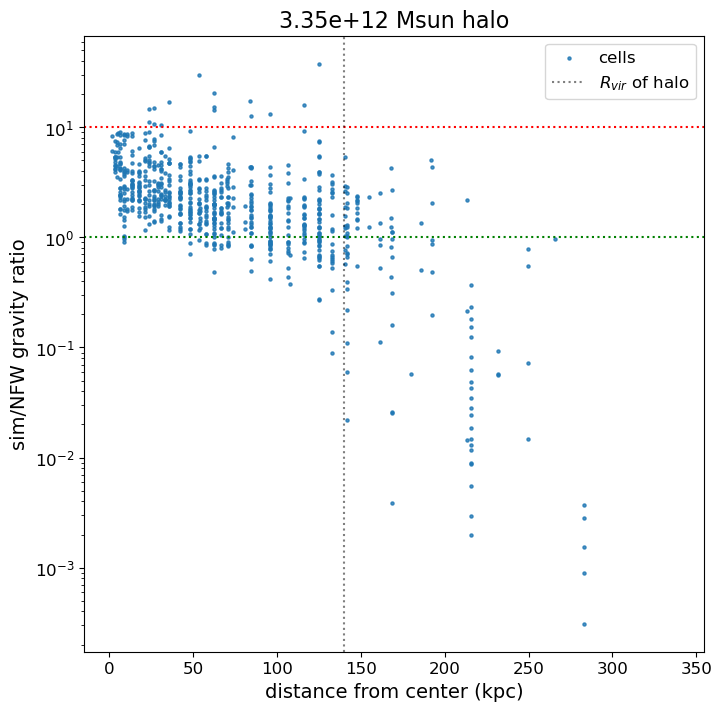

In [7]:
def gravity_comparison_NFW(cell_coords, dPsi_grid, Rvir, Mvir, cNFW, z=0):

    # NFW parameters.
    Rvir *= kpc
    Mvir *= 10**Mvir*Msun
    Rs = Rvir/cNFW
    rho0 = fct.scale_density_NFW(z, cNFW)

    # Calculate NFW value at cell coords.
    NFW_cells = np.array([
        fct.dPsi_dxi_NFW(x_i, z, rho0, Mvir, Rvir, Rs, 'HALO')
        for x_i in cell_coords
    ])/(kpc/s**2)
    NFW_mags = np.sqrt(np.sum(NFW_cells**2, axis=1))

    # Magnitudes of gravity in each cell.
    dPsi_mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))/(kpc/s**2)

    # Sort cells by distance from center (0,0,0).
    pos_grid = cell_coords/kpc
    grid_dist = np.sqrt(np.sum(pos_grid**2, axis=1))
    dist_order = grid_dist.argsort()

    grid_dist = grid_dist[dist_order]
    dPsi_mags = dPsi_mags[dist_order]
    NFW_mags = NFW_mags[dist_order]

    grav_ratio = dPsi_mags/NFW_mags
    print(f'dPsi/NFW: min={np.min(grav_ratio)}, max={np.max(grav_ratio)}')

    fig, ax = plt.subplots(1,1)

    ax.set_title(f'{Mvir/Msun:.2e} Msun halo')
    ax.scatter(
        grid_dist, grav_ratio, s=5, alpha=0.8, 
        label=f'cells'
    )
    ax.axhline(1, c='green', ls=':')
    ax.axhline(10, c='red', ls=':')
    ax.axhline(np.min(grav_ratio), c='red', ls=':')
    ax.axvline(
        Rvir/kpc, c='black', ls=':', alpha=0.5, 
        label=r'$R_{vir}$ of halo'
    )

    ax.set_xlabel('distance from center (kpc)')
    ax.set_ylabel('sim/NFW gravity ratio')

    ax.set_yscale('log')
    plt.legend()
    plt.show()



dPsi_raw = [np.load(f'X_tests/batch{b}_short_range.npy') for b in range(len(batch_arr))]
dPsi_grid = np.array(list(chain.from_iterable(dPsi_raw)))

gravity_comparison_NFW(
    cell_coords, dPsi_grid, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)

### Long-range gravity.

In [45]:
def chunksize_long_range(cells, core_mem_MB):
    
    # note: mem_MB specific to peak memory usage in cell_gravity_long_range.
    # -> Peak memory after calculation of derivative.

    elem = 8                          # 8 bytes for standard np.float64
    mem_type1 = 3*elem                # for derivative
    mem_type2 = cells*3*elem          # for quot
    mem_type3 = cells*elem            # for DM_count_sync

    mem_MB = (mem_type1+mem_type2+mem_type3)/1.e6

    batches = 1
    while mem_MB >= 0.95*core_mem_MB:
        mem_MB *= batches
        batches += 1
        mem_MB /= batches

    chunksize = math.ceil(cells/batches)

    return chunksize
    

def batch_generators_long_range(
    cell_coords, com_coords, DM_counts,
    chunksize 
):
    cells = len(cell_coords)
    cell_nums = np.arange(cells)

    batches = math.ceil(cells/chunksize)

    # Arrays used for naming files.
    id_arr = np.array([idx+1 for idx in cell_nums for _ in range(batches)])
    batch_arr = np.array([b+1 for _ in cell_nums for b in range(batches)])

    # Coord of cell, for which long-range gravity gets calculated.
    coord_arr = np.array([cc for cc in cell_coords for _ in range(batches)])

    # Chunks for DM_count array, as a generator for all cells.
    count_gens = (c for _ in cell_nums for c in chunks(chunksize, DM_counts))
    count_chain = chain(gen for gen in count_gens)

    # Chunks for cell_com array, as a generator for all cells.
    com_gens = (c for _ in cell_nums for c in chunks(chunksize, com_coords))
    com_chain = chain(gen for gen in com_gens)

    return id_arr, batch_arr, coord_arr, count_chain, com_chain
    

def cell_gravity_long_range(
    c_id, b_id, cellX_coords, 
    DM_count, cell_com, 
    DM_sim_mass, smooth_l, out_dir
):

    DM_count = np.array(DM_count)

    print(DM_count[DM_count == 1])

    # Distances between cell centers and cell c.o.m. coords.
    com_dis = np.expand_dims(
        np.sqrt(np.sum((cellX_coords-cell_com)**2, axis=1)), axis=1
    )

    # Offset DM positions by smoothening length of Camila's simulations.
    eps = smooth_l / 2.
    # eps = smooth_l

    # Long-range gravity component for each cell (including itself for now).
    quot = (cellX_coords-cell_com)/np.power((com_dis**2 + eps**2), 3./2.)
    DM_count_sync = np.expand_dims(DM_count, axis=1)
    del com_dis

    # Set self-gravity to zero.
    DM_count_sync[c_id, :] = 0.

    print(DM_count_sync.shape)

    # note: Minus sign, s.t. velocity changes correctly (see GoodNotes).
    derivative = -G*DM_sim_mass*np.sum(DM_count_sync*quot, axis=0)

    # note: Memory peaks here, due to these arrays:
    # print(quot.shape, DM_count_sync.shape, derivative.shape)
    # mem_inc = gso(quot)+gso(DM_count_sync)+gso(derivative)
    # print(mem_inc/1e6)
    del quot, DM_count_sync

    np.save(f'{out_dir}/cell{c_id}_batch{b_id}_long_range.npy', derivative)


def load_dPsi_long_range(c_id, batches, out_dir):
    
    # Load all batches for current cell.
    dPsi_raw = np.array(
        [np.load(f'{out_dir}/cell{c_id}_batch{b}_long_range.npy') for b in batches]
    )

    dPsi_for_cell = np.sum(dPsi_raw, axis=0)
    np.save(f'{out_dir}/cell{c_id}_long_range.npy', dPsi_for_cell)  

In [40]:
x_arr = np.arange(5)
x_arr[3] = 1

print(len(x_arr[x_arr == 1]))

2


In [46]:
print('SHAPES:', cell_coords.shape, DM_count.shape, cell_com.shape)
cells = len(cell_coords)


# Calculate available memory per core.
mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
mem_left = PRE.MEM_LIM_GB*1e3 - mem_so_far
core_mem_MB = mem_left / PRE.PRE_CPUs
print('Per core mem (GB):', core_mem_MB/1e3)

# Determine long-range chuncksize based on available memory and cells.
chunksize_lr = chunksize_long_range(cells, core_mem_MB)

# Split workload into batches (if necessary).
ids, batches, coords, count_chain, com_chain = batch_generators_long_range(
    cell_coords, cell_com, DM_count, chunksize_lr
)


# Memory profile the long-range gravity function.
in1 = ids[0]
in2 = batches[0]
in3 = coords[0]
in4 = next(count_chain)
in5 = next(com_chain)

cell_gravity_long_range(
    in1,in2,in3,in4,in5,PRE.DM_SIM_MASS,PRE.SMOOTH_L,TEMP_DIR
)

# Pass arrays and chains of generators to multiprocessing routine.
# with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
#     ex.map(
#         cell_gravity_long_range, ids, batches, 
#         coords, count_chain, com_chain,
#         repeat(PRE.DM_SIM_MASS), repeat(PRE.SMOOTH_L), repeat(TEMP_DIR)
#     )

SHAPES: (792, 3) (792,) (792, 3)
Per core mem (GB): 1.37496533203125
[1]
(792, 1)


In [30]:
# with self-gravity
test = np.load(f'{TEMP_DIR}/cell792_batch1_long_range.npy')
print(test)

[-2.46316066e-33 -2.48111768e-33  1.01995985e-33]


In [27]:
# without self-gravity
test = np.load(f'{TEMP_DIR}/cell792_batch1_long_range.npy')
print(test)

[-2.46316066e-33 -2.48111768e-33  1.01995985e-33]


In [35]:
# Pass arrays and chains of generators to multiprocessing routine.
with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
    ex.map(
        load_dPsi_long_range, ids, 
        repeat(np.unique(batches)), repeat(TEMP_DIR)
    )

# Save long-range gravity (a [x,y,z] array) for all cells.
dPsi_cells = [np.load(f'{TEMP_DIR}/cell{c}_long_range.npy') for c in ids]
np.save(f'{TEMP_DIR}/dPsi_grid_{IDname}.npy', np.array(dPsi_cells))

print(np.array(dPsi_cells).shape)

(792, 3)


dPsi/NFW: min=1.0152582126447574, max=153.00351906821905


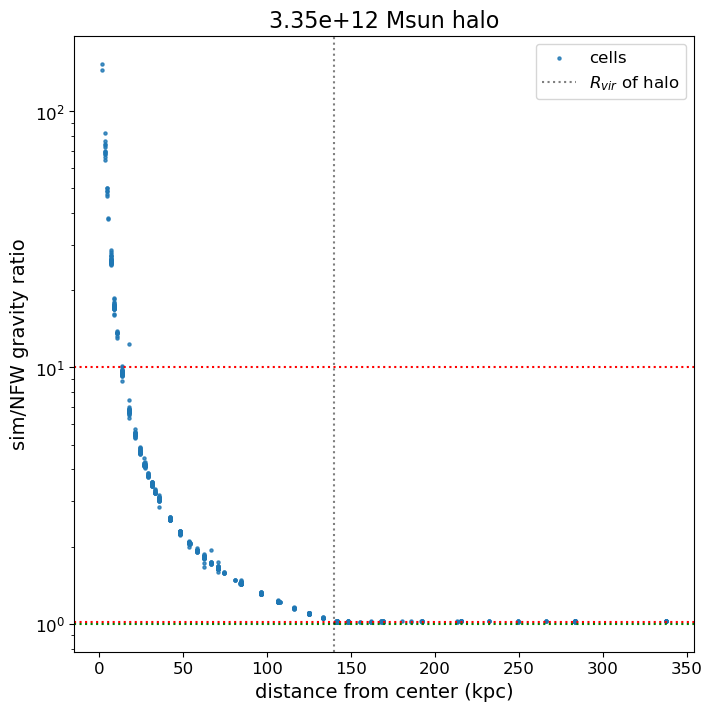

In [36]:
dPsi_raw = [np.load(f'X_tests/batch{b}_short_range.npy') for b in range(len(batch_arr))]
dPsi_sr = np.array(list(chain.from_iterable(dPsi_raw)))

dPsi_lr = np.array(dPsi_cells)

# dPsi_grid = dPsi_sr #+ dPsi_lr
dPsi_grid = dPsi_lr

gravity_comparison_NFW(
    cell_coords, dPsi_grid, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)